In [5]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import torch
from torch.utils.data import random_split,DataLoader,TensorDataset
from PIL import Image
import torchvision
import os
import random
from torchvision import models,transforms,datasets
from torchvision.models import ResNet18_Weights

### Actividad de CNN

In [6]:
transform_base = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform_augmented = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [7]:
from torchvision.datasets import ImageFolder

class CustomImageFolder(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        
        # Si la clase es 2 o 3, aplica aumento especial
        if target in [2, 3]:
            sample = transform_augmented(sample)
        else:
            sample = transform_base(sample)
        
        return sample, target


In [8]:
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

path = "pieces"

dataset = datasets.ImageFolder(path,transform=transform)
train_dataset = CustomImageFolder(path)

train_set,val_set,test_set = random_split(train_dataset,[400-1,125,126],generator=torch.Generator().manual_seed(619))

val_set.dataset.transform = transform_base
test_set.dataset.transform = transform_base

train_loader = DataLoader(train_set,batch_size=32,shuffle=True)
val_loader = DataLoader(val_set,batch_size=32,shuffle=False)
test_loader = DataLoader(test_set,batch_size=32,shuffle=False)   

En el siguiente bloque explore la data, con el fin de responder a estas preguntas.  
- ¿De que se trata el dataset?
- ¿Cuales son las clases de salida?
- ¿Cuantas imagenes hay por clase?
- ¿Cual es el tamaño de las imagenes?
- ¿Cuantas imagenes hay en total?
- Grafique algunas imagenes de cada clase
- etc.

In [9]:
#Para mostrar X imagenes aleatorias
X = 5
indices = random.sample(range(len(dataset)), X)
print(indices)

[603, 133, 128, 63, 584]


Clases: ['bishop', 'knight', 'pawn', 'queen', 'rook']
{'bishop': 0, 'knight': 1, 'pawn': 2, 'queen': 3, 'rook': 4}

Cantidad de imagenes: 650
Cantidad de alfiles : 141
Cantidad de Caballos : 174
Cantidad de Peones : 81
Cantidad de Reinas : 115
Cantidad de Torre : 139

Ya que se redimensionaron las imagenes a 224x244 en transform, todas las imagenes tendrán ese tamaño
torch.Size([3, 224, 224])

Total de imágenes: 650


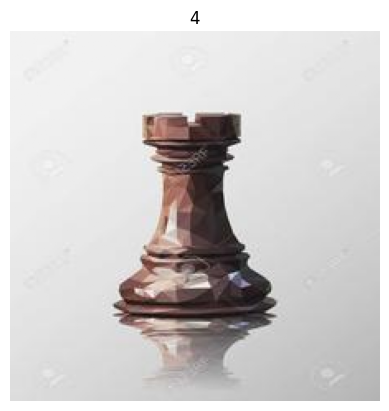

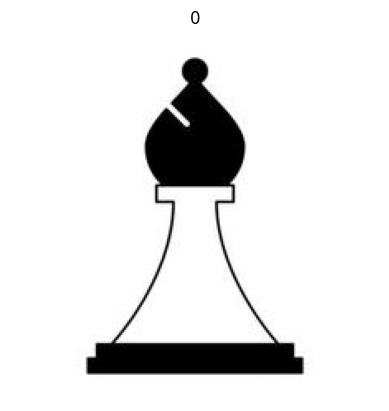

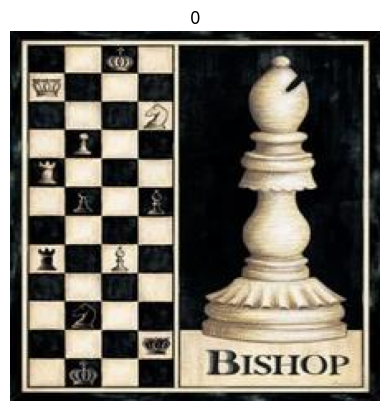

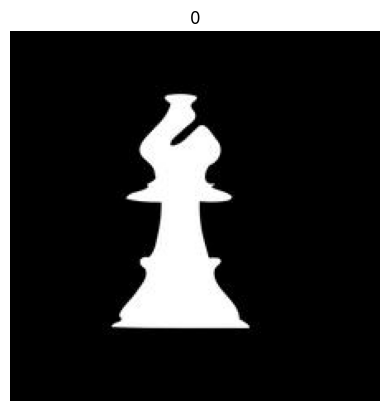

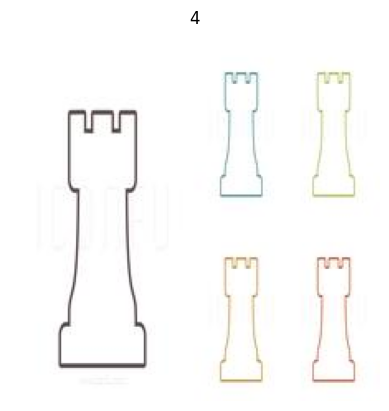

In [10]:
""" De que trata el dataset? """
# Viendo la carpeta de las imagenes, podemos observar que se tienen diferentes carpetas en las que se encuentran
# imagenes de diferentes piezas de ajegrez, como lo son alfil, caballo, peon, reina y torre.

""" Cuales son las clases? """
print(f"Clases: {dataset.classes}")

""" Cuantas imagenes hay por clase """
print(dataset.class_to_idx)
print(f"\nCantidad de imagenes: {len(dataset)}")
print(f"Cantidad de alfiles : {dataset.targets.count(0)}")
print(f"Cantidad de Caballos : {dataset.targets.count(1)}")
print(f"Cantidad de Peones : {dataset.targets.count(2)}")
print(f"Cantidad de Reinas : {dataset.targets.count(3)}")
print(f"Cantidad de Torre : {dataset.targets.count(4)}")

""" Cuál es el tamaño de las imágenes? """
print("\nYa que se redimensionaron las imagenes a 224x244 en transform, todas las imagenes tendrán ese tamaño")
img,_ = dataset[384]
print(img.shape)

""" Cuántas imágenes hay en total? """
print("\nTotal de imágenes:", len(dataset))
# Originalmente eran 651 imagenes, pero debimos eliminar una la cual su contenido era simplemente una imagen en negro, 
# lo cual podría perjudicar el aprendizaje del modelo

""" Grafique algunas imagenes de cada clase """
for i in indices:
    img,idx = dataset[i]
    plt.imshow(img.permute(1,2,0))
    plt.title(idx)
    plt.axis("off")
    plt.show()

En el siguiente bloque implemente el modelo que le permitirá clasificar las diferentes tipos de piezas en el ajedrez, justifique la arquitectura de la red.

In [11]:
from torchvision.models import resnet18, ResNet18_Weights


class ModelResNetMate(nn.Module):

    def __init__(self, num_classes=5):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT
        self.model = resnet18(weights=weights)

        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

In [12]:
# Cargar modelo preentrenado
model =  ModelResNetMate() # .resnet18(pretrained=True) 

# Solo entrenaremos la última capa (fully connected - fc)
for param in model.parameters():
    param.requires_grad = False # Congelamos el resto
for param in model.model.fc.parameters():
    param.requires_grad = True # Activamos el gradiente para la última capa

En el siguiente bloque cree una instancia de su red neuronal convolucional definida anteriormente y defina una función de perdida y un optimizador.	

In [13]:
class_counts = np.bincount(dataset.targets)
weights = 1. / torch.tensor(class_counts, dtype=torch.float)

criterion = nn.CrossEntropyLoss() # Para la clasificacion de las 5 clases
optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay=1e-4) # Optimizador que ajusta automaticamente el learning rate

# Weight_decay es un hiperparámetro para regularizar el modelo y evitar un sobreajuste 
# Es una forma de penalizar los pesos grandes durante el entrenamiento y que el modelo se mantenga a generalizar datos nuevos
# Lo usamos ya que probamos con un modelo anteriormente que tenía este problema, y al usarlo con el nuevo modelo mostró una
# mejora en las métricas, por lo que decidimos mantenerlo.

En el siguiente bloque programe el entrenamiento de su red neuronal convolucional.

In [ ]:
num_epoch = 20
running_loss = np.zeros(shape=(num_epoch, 2)) # Para almacenar las perdidas promedio en train y val


for i in range(num_epoch):
    train_loss, valid_loss = 0.0, 0.0 # Para calcular la perdida por época

     # ---- Entrenamiento ----
    model.train()
    for img,index in train_loader:
        outputs = model(img) # Predicción
        loss = criterion(outputs,index)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() 

    # ---- Validación (Accuracy) ----
    model.eval()
    for img,index in val_loader:
        with torch.no_grad(): # no cálculamos gradiente para validación
            outputs = model(img)
            loss = criterion(outputs,index)
            valid_loss += loss.item()
    

    # -----------------------------------

    # Calculamos la perdida promedio por epoca (ya que cada batch tiene su propia perdida)
    avg_train_loss = train_loss/len(train_loader.dataset)
    avg_valid_loss = valid_loss/len(val_loader.dataset)
    running_loss[i] = avg_train_loss, avg_valid_loss
    
    print(f"Epoch [{i+1}/{num_epoch}], Loss: {loss.item():.4f}")


Epoch [1/20], Loss: 1.4470
Epoch [2/20], Loss: 1.2167
Epoch [3/20], Loss: 1.0036
Epoch [4/20], Loss: 0.9736
Epoch [5/20], Loss: 0.8576
Epoch [6/20], Loss: 0.7406
Epoch [7/20], Loss: 0.7869
Epoch [8/20], Loss: 0.6661
Epoch [9/20], Loss: 0.6939
Epoch [10/20], Loss: 0.6217
Epoch [11/20], Loss: 0.5797
Epoch [12/20], Loss: 0.5655
Epoch [13/20], Loss: 0.5533
Epoch [14/20], Loss: 0.5598
Epoch [15/20], Loss: 0.5099
Epoch [16/20], Loss: 0.5709
Epoch [17/20], Loss: 0.5594
Epoch [18/20], Loss: 0.4927
Epoch [19/20], Loss: 0.5000
Epoch [20/20], Loss: 0.4952


En el siguiente bloque muestre el gráfico de entrenamiento y validación de su red neuronal convolucional.

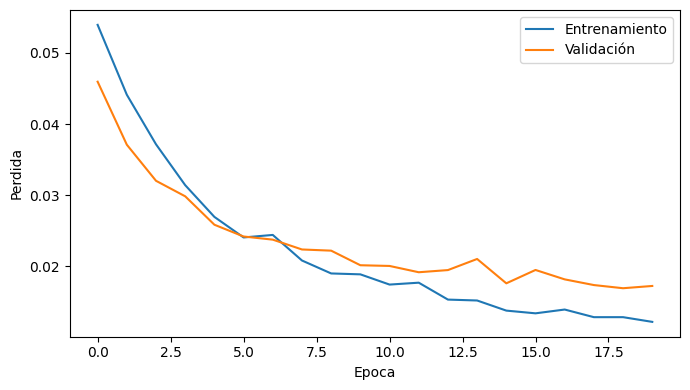

In [15]:
fig, ax = plt.subplots(figsize=(7, 4), tight_layout=True)
ax.plot(running_loss[:, 0], label='Entrenamiento')
ax.plot(running_loss[:, 1], label='Validación')
ax.set_xlabel('Epoca')
ax.set_ylabel('Perdida')
ax.legend()

Muestre diferentes métricas de evaluación de su red neuronal convolucional.

METRICAS EN TEST
Accuracy:  79.37%
Precision: 79.28%
Recall:    79.37%
F1 Score:  79.14%



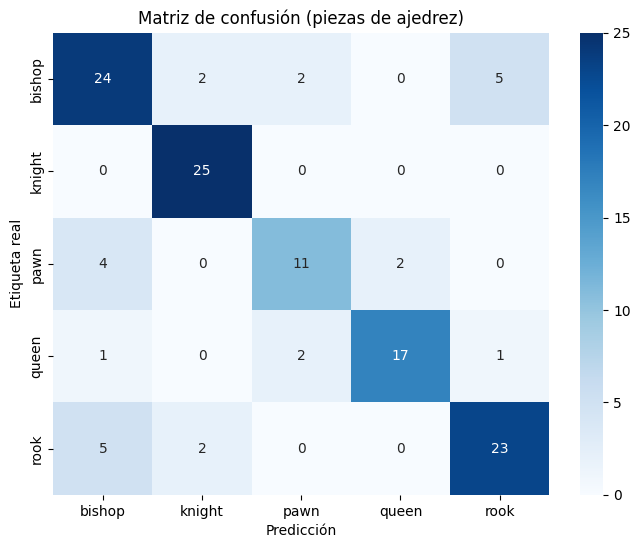

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

correct = 0
total = 0
# Recolectar todas las predicciones y etiquetas verdaderas
all_preds = []
all_index = []
with torch.no_grad():
   for img,index in test_loader:
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        total += index.size(0)
        correct += (predicted == index).sum().item()
        all_preds.extend(predicted.numpy())
        all_index.extend(index.numpy())

print("METRICAS EN TEST")
acc = accuracy_score(all_index, all_preds)
prec = precision_score(all_index, all_preds, average='weighted')
rec = recall_score(all_index, all_preds, average='weighted')
f1 = f1_score(all_index, all_preds, average='weighted')
print(f"Accuracy:  {acc:.2%}")
print(f"Precision: {prec:.2%}")
print(f"Recall:    {rec:.2%}")
print(f"F1 Score:  {f1:.2%}\n")

# Nombres de las clases según su orden numérico
class_names = ['bishop', 'knight', 'pawn', 'queen', 'rook']

# Calcular matriz de confusión
cm = confusion_matrix(all_index, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión (piezas de ajedrez)")
plt.show()


Concluya sobre las métricas obtenidas y el entrenamiento de su red neuronal convolucional.

En el siguiente bloque muestre las predicciones de su red neuronal convolucional y responda:
- ¿Cree que los errores son razonables?
- ¿Qué haría para mejorar la clasificación de las piezas de ajedrez?
